In [67]:
from typing import List
from copy import deepcopy

import random
import collections

import h5py

import matplotlib.pyplot as plt; plt.rcParams.update({"font.family": "serif"})

import pyscf
import pyscf.cc
import pyscf.mcscf

# To get molecular geometries.
import openfermion as of
from openfermion import MolecularData
from openfermionpyscf import run_pyscf

import qiskit
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.primitives import BitArray
from qiskit_aer import AerSimulator  # For MPS Simulator.
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.primitives import BackendEstimatorV2 as BackendEstimator
from qiskit.transpiler.passes import RemoveFinalMeasurements
from qiskit.qasm2 import dumps

import ffsim

# To run on hardware.
import qiskit_ibm_runtime
from qiskit_ibm_runtime import SamplerV2 as Sampler

from functools import partial, reduce

import numpy as np

# from qiskit_addon_sqd.fermion import SCIResult, diagonalize_fermionic_hamiltonian, solve_sci_batch
from qiskit_addon_sqd.qubit import solve_qubit, sort_and_remove_duplicates, project_operator_to_subspace

from adaptvqe.pools import DVG_CEO, FullPauliPool, TiledPauliPool
from adaptvqe.convert import cirq_pauli_sum_to_qiskit_pauli_op
from adaptvqe.hamiltonians import XXZHamiltonian
from adaptvqe.algorithms.adapt_vqe import LinAlgAdapt, TensorNetAdapt

In [68]:
ibm_computer: str = "ibm_fez"

service = qiskit_ibm_runtime.QiskitRuntimeService(channel="local")
computer = service.backend()
sampler = Sampler(computer)

## Build a tiled pool

In [69]:
max_mpo_bond = 300
dmrg_mps_bond = 30
adapt_mps_bond = 30
l = 4

j_xy = 1
j_z = 1
h = XXZHamiltonian(j_xy, j_z, l, diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond)
dmrg_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")
pool = FullPauliPool(n=l, max_mpo_bond=max_mpo_bond)

# Run 200 iterations of ADAPT-VQE for small problem instance, selecting randomly among degenerate gradients.
# Form a list of all unique operators ever selected for this small instance.
ixs = []
for _ in range(30):
    my_adapt = TensorNetAdapt(
        pool=pool,
        custom_hamiltonian=h,
        verbose=False,
        threshold=10**-5,
        max_adapt_iter=5,
        max_opt_iter=10000,
        sel_criterion="gradient",
        recycle_hessian=False,
        rand_degenerate=True,
        max_mpo_bond=100,
        max_mps_bond = 20
    )
    my_adapt.run()
    data = my_adapt.data
    for i in data.result.ansatz.indices:
        if i not in ixs:
            ixs.append(i)

print(f"Pool will be tiled from {len(ixs)} ops")
source_ops = [pool.operators[index].operator for index in ixs]

Got DMRG energy -6.46410e+00

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float64(0.0)]

Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474288453)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 198]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819708
(change of -0.2041705292020657)
Current ansatz: [241, 79, 228, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531757
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.089492926734934)]
Initial energy: -6.327276154819708
Optimizing energy with indices [241, 79, 228, 198, 45]...
Starting point: [np.float64(-0.7853981618473267), np.float64(0.7853981651745618), np.float64(0.16357019740836948), np.float64(-0.16356963668286137), np.float64(0.0)]

Current energy: -6.464101615134384
(change of -0.13682546031467613)
Current ansatz: [241, 79, 228, 198, 45]
Performing final convergence check...
Total gradient norm: 2.929018984664254e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531757 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617647
(change of -0.12310562561764193)
Current ansatz: [241, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292965)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 147]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819989
(change of -0.2041705292023419)
Current ansatz: [241, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042617831
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.08949164278134)]
Initial energy: -6.327276154819989
Optimizing energy with indices [241, 79, 225, 147, 210]...
Starting point: [np.float64(-0.7853981633974467)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -4.626284539634973
(change of -0.7978574148887763)
Current ansatz: [211, 241]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 12.26780273456531
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-3.7252880142064084)]
Initial energy: -4.626284539634973
Optimizing energy with indices [211, 241, 79]...
Starting point: [np.float64(-0.2651612342265216), np.float64(-0.44546905390000224), np.float64(0.0)]

Current energy: -6.123105625614734
(change of -1.4968210859797608)
Current ansatz: [211, 241, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917530720141803
Operator(s) added to ansatz: [177]
Gradients: [np.float64(-2.485073566996777)]
Initial energy: -6.123105625614734
Optimizing energy with indices [211, 241, 79, 177]...
Starting point: [np.float64(-0.122489928621197), np.float64(-0.7853981633782835), np.float64(0.7

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199441697
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.485071047428846)]
Initial energy: -6.123105625617642
Optimizing energy with indices [241, 79, 228, 135]...
Starting point: [np.float64(-0.785398162647287), np.float64(0.7853981641254796), np.float64(0.1224892793433147), np.float64(0.0)]

Current energy: -6.32727615481999
(change of -0.20417052920234813)
Current ansatz: [241, 79, 228, 135]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964043989466
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916415770357)]
Initial energy: -6.32727615481999
Optimizing energy with indices [241, 79, 228, 135, 198]...
Starting point: [np.float64(-0.7853981865515778), np.float64(0.785398160349101), np.float64(0.16357028664406387), np.float64(0.16356997254179764), np.float64(0.0)]

Current energy: -6.464101614980915
(change of -0.13682546016092534)
Current ansatz:

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00018441503393950355

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964043989466 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 79]...
Starting point: [np.float64(-0.5535743588970441), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944251
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429297)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 79, 225, 210]...
Starting point: [np.float64(-0.7853981627578538), np.float64(0.78539816425353), np.float64(-0.12248927934343061), np.float64(0.0)]

Current energy: -6.327276154819705
(change of -0.2041705292020577)
Current ansatz: [241, 79, 225, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531791
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.089492926734878)]
Initial energy: -6.327276154819705
Optimizing energy with indices [241, 79, 225, 210, 198]...
Starting point: [np.float64(-0.7853981607743267), np.float64(0.7853981678304174), np.float64(-0.163570197408367), np.float64(0.16356963668287403), np.float64(0.0)]

Current energy: -6.464101615008455
(change of -0.1368254601887502)
Current ansatz: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752620004858
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710477670868)]
Initial energy: -6.123105625617647
Optimizing energy with indices [244, 74, 228, 147]...
Starting point: [np.float64(0.7853981659552435), np.float64(-0.7853981611613353), np.float64(0.12248927943047701), np.float64(0.0)]

Current energy: -6.327276154819713
(change of -0.2041705292020657)
Current ansatz: [244, 74, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531879
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.089492926734878)]
Initial energy: -6.327276154819713
Optimizing energy with indices [244, 74, 228, 147, 210]...
Starting point: [np.float64(0.7853981767049507), np.float64(-0.7853981525341226), np.float64(0.16357019740838014), np.float64(-0.1635696366828784), np.float64(0.0)]

Current energy: -6.464101614750672
(change of -0.13682545993095907)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999998188
(change of -1.7639320224983939)
Current ansatz: [177, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971140572
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-1.9999999999944214)]
Initial energy: -5.999999999998188
Optimizing energy with indices [177, 31, 228]...
Starting point: [np.float64(-0.7853985607314273), np.float64(-0.7853989420959481), np.float64(0.0)]

Current energy: -6.123105625610641
(change of -0.1231056256124532)
Current ansatz: [177, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917522148955644
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485068789868894)]
Initial energy: -6.123105625610641
Optimizing energy with indices [177, 31, 228, 210]...
Starting point: [np.float64(-0.7853983869831804), np.float64(-0.7853991695302192), np.float64(0.1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047430588)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 147]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]

Current energy: -6.327276154820074
(change of -0.20417052920242362)
Current ansatz: [244, 79, 225, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963655680355
Operator(s) added to ansatz: [120]
Gradients: [np.float64(-2.089491982574535)]
Initial energy: -6.327276154820074
Optimizing energy with indices [244, 79, 225, 147, 120]...
Starting point: [np.float64(0.7853981479801436), np.float64(0.7853981834326691), np.float64(-0.16357026296685157), np.float64(-0.16356988342672032), np.float64(0.0)]

Current energy: -6.464101615066587
(change of -0.13682546024651288)
Current ans

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013897882250844647

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963655680355 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [74]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 74]...
Starting point: [np.float64(-0.5535743588970441), np.float6

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 9.355247463480744e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531976 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [79]
Gradients: [np.float64(-4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 79]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819987
(change of -0.20417052920234813)
Current ansatz: [244, 79, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964041846258
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916434588646)]
Initial energy: -6.327276154819987
Optimizing energy with indices [244, 79, 228, 210, 198]...
Starting point: [np.float64(0.7853981591889313), np.float64(0.7853981652005415), np.float64(0.16357028651334282), np.float64(0.1635699720499918), np.float64(0.0)]

Current energy: -6.464101615072706
(change of -0.13682546025271858)
Current ansatz: [244, 79, 228, 210, 198]
Performing final convergence check...
Total gradient norm: 0.00013508605500525537

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.4850710474292024)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 147]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.12248927934340699), np.float64(0.0)]

Current energy: -6.327276154819699
(change of -0.20417052920205947)
Current ansatz: [244, 79, 228, 147]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531783
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.0894929267348745)]
Initial energy: -6.327276154819699
Optimizing energy with indices [244, 79, 228, 147, 45]...
Starting point: [np.float64(0.7853981646904773), np.float64(0.7853981643651435), np.float64(0.16357019740836662), np.float64(-0.1635696366828739), np.float64(0.0)]

Current energy: -6.464101615131512
(change of -0.13682546031181353)
Current ansatz

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.1231056256007985
(change of -0.12310562567128258)
Current ansatz: [228, 26, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752996715211
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.485073147248)]
Initial energy: -6.1231056256007985
Optimizing energy with indices [228, 26, 210, 225]...
Starting point: [np.float64(-0.7853960819261802), np.float64(0.7853979331209127), np.float64(0.1224898204618799), np.float64(0.0)]

Current energy: -6.327276154801719
(change of -0.20417052920092083)
Current ansatz: [228, 26, 210, 225]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962581069684
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.089492926705316)]
Initial energy: -6.327276154801719
Optimizing energy with indices [228, 26, 210, 225, 201]...
Starting point: [np.float64(-0.7853960819261787)

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.0000000000000058)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 216]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.1231056256176366)
Current ansatz: [241, 31, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200767483
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850710481677654)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 216, 201]...
Starting point: [np.float64(-0.7853981626365961), np.float64(-0.7853981627961343), np.float64(-0.

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 3.874599970985359e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531914 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [241]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [241]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499796
(change of -1.2360679774997916)
Current ansatz: [241]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.85333868569617
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000005)]
Initial energy: -4.236067977499796
Optimizing energy with indices [241, 31]...
Starting point: [np.float64(-0.5535743588970441), np.float64

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.91752619944177
Operator(s) added to ansatz: [45]
Gradients: [np.float64(-2.4850710474288835)]
Initial energy: -6.123105625617648
Optimizing energy with indices [241, 31, 225, 45]...
Starting point: [np.float64(-0.7853981605940241), np.float64(-0.7853981659075159), np.float64(-0.12248927934332374), np.float64(0.0)]

Current energy: -6.327276154819719
(change of -0.20417052920207102)
Current ansatz: [241, 31, 225, 45]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531839
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894929267348754)]
Initial energy: -6.327276154819719
Optimizing energy with indices [241, 31, 225, 45, 198]...
Starting point: [np.float64(-0.7853981499557928), np.float64(-0.785398177188549), np.float64(-0.1635701974083672), np.float64(0.16356963668287564), np.float64(0.0)]

Current energy: -6.464101614763143
(change of -0.13682545994342377)
Current ansa

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00030817030776114597

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531839 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [211]
Gradients: [np.float64(4.000000000000012)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [211]...
Starting point: [np.float64(0.0)]

Current energy: -3.828427124746197
(change of -0.8284271247461925)
Current ansatz: [211]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.78207252017211
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-3.4142135623691776)]
Initial energy: -3.828427124746197
Optimizing energy with indices [211, 244]...
Starting point: [np.float64(-0.3926990817001106), np.fl

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999417229
(change of -1.3737154597822618)
Current ansatz: [211, 244, 79]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958970181085
Operator(s) added to ansatz: [216]
Gradients: [np.float64(1.9999999998057452)]
Initial energy: -5.999999999417229
Optimizing energy with indices [211, 244, 79, 216]...
Starting point: [np.float64(-9.855379305101342e-06), np.float64(0.7853981714334987), np.float64(0.7853981407341446), np.float64(0.0)]

Current energy: -6.123105625027778
(change of -0.12310562561054894)
Current ansatz: [211, 244, 79, 216]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526189818066
Operator(s) added to ansatz: [99]
Gradients: [np.float64(-2.485071042304514)]
Initial energy: -6.123105625027778
Optimizing energy with indices [211, 244, 79, 216, 99]...
Starting point: [np.float64(-9.81492285375244

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617651
(change of -0.12310562561764193)
Current ansatz: [244, 79, 225]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199444833
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710474305875)]
Initial energy: -6.123105625617651
Optimizing energy with indices [244, 79, 225, 198]...
Starting point: [np.float64(0.7853981583089785), np.float64(0.785398168718093), np.float64(-0.12248927934376257), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.32727615482008
(change of -0.20417052920242895)
Current ansatz: [244, 79, 225, 198]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240963610610418
Operator(s) added to ansatz: [135]
Gradients: [np.float64(-2.089492022153505)]
Initial energy: -6.32727615482008
Optimizing energy with indices [244, 79, 225, 198, 135]...
Starting point: [np.float64(0.7853981493735948), np.float64(0.7853981777037257), np.float64(-0.16357026021874255), np.float64(-0.16356987308330864), np.float64(0.0)]

Current energy: -6.464101615050828
(change of -0.1368254602307486)
Current ansatz: [244, 79, 225, 198, 135]
Performing final convergence check...
Total gradient norm: 0.00014811047136609125

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240963610610418 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating lis

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819971
(change of -0.2041705292023286)
Current ansatz: [241, 74, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964057733311
Operator(s) added to ansatz: [57]
Gradients: [np.float64(2.089491629507777)]
Initial energy: -6.327276154819971
Optimizing energy with indices [241, 74, 228, 210, 57]...
Starting point: [np.float64(-0.785398162447052), np.float64(-0.7853981711958521), np.float64(0.16357028748210503), np.float64(0.16356997569593643), np.float64(0.0)]

Current energy: -6.464101615067938
(change of -0.13682546024796682)
Current ansatz: [241, 74, 228, 210, 57]
Performing final convergence check...
Total gradient norm: 0.00013840069558915347

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964057733311 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list o

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 31]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132743
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.0000000000000018)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 31, 228]...
Starting point: [np.float64(-0.7853981718257756), np.float64(-0.7853981815917112), np.float64(0.0)]

Current energy: -6.123105625617647
(change of -0.1231056256176366)
Current ansatz: [241, 31, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199441852
Operator(s) added to ansatz: [147]
Gradients: [np.float64(2.485071047428929)]
Initial energy: -6.123105625617647
Optimizing energy with indices [241, 31, 228, 147]...
Starting point: [np.float64(-0.7853981609748782), np.float64(-0.785398165605737), np.float64(0.122

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000011
(change of -1.7639320225002146)
Current ansatz: [241, 26]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.79795897113274
Operator(s) added to ansatz: [216]
Gradients: [np.float64(2.000000000000005)]
Initial energy: -6.000000000000011
Optimizing energy with indices [241, 26, 216]...
Starting point: [np.float64(-0.7853981718257758), np.float64(0.7853981815917098), np.float64(0.0)]

Current energy: -6.123105625617644
(change of -0.12310562561763305)
Current ansatz: [241, 26, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526200770151
Operator(s) added to ansatz: [156]
Gradients: [np.float64(-2.485071048169255)]
Initial energy: -6.123105625617644
Optimizing energy with indices [241, 26, 216, 156]...
Starting point: [np.float64(-0.7853981650265022), np.float64(0.7853981646314862), np.float64(-0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819705
(change of -0.20417052920206125)
Current ansatz: [241, 26, 216, 156]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580531799
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.089492926735055)]
Initial energy: -6.327276154819705
Optimizing energy with indices [241, 26, 216, 156, 225]...
Starting point: [np.float64(-0.7853981660307093), np.float64(0.7853981691726957), np.float64(-0.16357019740840442), np.float64(0.16356963668284105), np.float64(0.0)]

Current energy: -6.4641016151230035
(change of -0.13682546030329856)
Current ansatz: [241, 26, 216, 156, 225]
Performing final convergence check...
Total gradient norm: 5.269047862335745e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580531799 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating l

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917526201775818
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.4850710484682823)]
Initial energy: -6.1231056255624825
Optimizing energy with indices [228, 26, 228, 210]...
Starting point: [np.float64(-0.7853947065772612), np.float64(0.7853985308794263), np.float64(0.12248927961669973), np.float64(0.0)]

Current energy: -6.327276154765017
(change of -0.20417052920253465)
Current ansatz: [228, 26, 228, 210]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240964042069122
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.0894916438633278)]
Initial energy: -6.327276154765017
Optimizing energy with indices [228, 26, 228, 210, 198]...
Starting point: [np.float64(-0.7853947065771328), np.float64(0.7853982468601286), np.float64(0.16357028648716873), np.float64(0.16356997194353046), np.float64(0.0)]

Current energy: -6.4641016150180075
(change of -0.13682546025299036)
Current

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -5.999999999929518
(change of -1.7639320224297226)
Current ansatz: [228, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971647986
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000019367)]
Initial energy: -5.999999999929518
Optimizing energy with indices [228, 79, 228]...
Starting point: [np.float64(-0.7853947065773552), np.float64(0.7853993777262496), np.float64(0.0)]

Current energy: -6.123105625562482
(change of -0.1231056256329639)
Current ansatz: [228, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526201775814
Operator(s) added to ansatz: [198]
Gradients: [np.float64(2.4850710484682805)]
Initial energy: -6.123105625562482
Optimizing energy with indices [228, 79, 228, 198]...
Starting point: [np.float64(-0.7853947065772693), np.float64(0.7853985308794288), np.float64(0.1224

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625614727
(change of -1.49682108597976)
Current ansatz: [211, 244, 31]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917530720521563
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.485073567208433)]
Initial energy: -6.123105625614727
Optimizing energy with indices [211, 244, 31, 201]...
Starting point: [np.float64(-0.12248992867574016), np.float64(0.7853981549207331), np.float64(-0.7853981610270105), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.327276154819711
(change of -0.20417052920498424)
Current ansatz: [211, 244, 31, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962580955357
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.0894929267315017)]
Initial energy: -6.327276154819711
Optimizing energy with indices [211, 244, 31, 201, 225]...
Starting point: [np.float64(-0.16357019750392648), np.float64(0.7853981548243515), np.float64(-0.785398159357834), np.float64(0.16356963671034297), np.float64(0.0)]

Current energy: -6.4641016151349096
(change of -0.13682546031519838)
Current ansatz: [211, 244, 31, 201, 225]
Performing final convergence check...
Total gradient norm: 2.7167511487574445e-05

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962580955357 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000005
(change of -1.7639320225002093)
Current ansatz: [241, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132733
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.0000000000000044)]
Initial energy: -6.000000000000005
Optimizing energy with indices [241, 79, 210]...
Starting point: [np.float64(-0.785398171825775), np.float64(0.7853981815917083), np.float64(0.0)]

Current energy: -6.12310562561764
(change of -0.12310562561763483)
Current ansatz: [241, 79, 210]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199634684
Operator(s) added to ansatz: [225]
Gradients: [np.float64(2.4850710475364073)]
Initial energy: -6.12310562561764
Optimizing energy with indices [241, 79, 210, 225]...
Starting point: [np.float64(-0.7853981634187125), np.float64(0.7853981633741678), np.float64(0.12248

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 8.917518430081312
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.4850667159374624)]
Initial energy: -6.1231056252069065
Optimizing energy with indices [228, 79, 216, 201]...
Starting point: [np.float64(-0.7853879048615375), np.float64(0.7853901599313474), np.float64(-0.12248816317024809), np.float64(0.0)]


/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.3272761548213765
(change of -0.20417052961447002)
Current ansatz: [228, 79, 216, 201]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.240962087341802
Operator(s) added to ansatz: [177]
Gradients: [np.float64(-2.089491704704269)]
Initial energy: -6.3272761548213765
Optimizing energy with indices [228, 79, 216, 201, 177]...
Starting point: [np.float64(-0.785398172787821), np.float64(0.7853981748078923), np.float64(-0.1635698366550077), np.float64(0.16356985419052347), np.float64(0.0)]

Current energy: -6.464101614959846
(change of -0.13682546013846952)
Current ansatz: [228, 79, 216, 201, 177]
Performing final convergence check...
Total gradient norm: 0.00021445472702253258

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240962087341802 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.000000000000009
(change of -1.7639320225002102)
Current ansatz: [244, 79]

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 9.797958971132738
Operator(s) added to ansatz: [228]
Gradients: [np.float64(-2.000000000000001)]
Initial energy: -6.000000000000009
Optimizing energy with indices [244, 79, 228]...
Starting point: [np.float64(0.7853981718257751), np.float64(0.7853981815917103), np.float64(0.0)]

Current energy: -6.123105625617639
(change of -0.12310562561763039)
Current ansatz: [244, 79, 228]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.917526199442337
Operator(s) added to ansatz: [210]
Gradients: [np.float64(-2.485071047429203)]
Initial energy: -6.123105625617639
Optimizing energy with indices [244, 79, 228, 210]...
Starting point: [np.float64(0.785398163526392), np.float64(0.7853981635468582), np.float64(0.122489

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Total gradient norm: 0.00013508605784767053

The maximum number of iterations (5) was hit before the convergence criterion was satisfied.
(current gradient norm is 6.240964041846258 > 1e-05)

Initial energy: -3.0000000000000044

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 19.595917942265466
Operator(s) added to ansatz: [244]
Gradients: [np.float64(-4.000000000000005)]
Initial energy: -3.0000000000000044
Optimizing energy with indices [244]...
Starting point: [np.float64(0.0)]

Current energy: -4.236067977499799
(change of -1.2360679774997942)
Current ansatz: [244]

*** ADAPT-VQE Iteration 2 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 14.853338685696167
Operator(s) added to ansatz: [31]
Gradients: [np.float64(4.000000000000007)]
Initial energy: -4.236067977499799
Optimizing energy with indices [244, 31]...
Starting point: [np.float64(0.5535743588970456), np.float

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")



Current energy: -6.123105625617655
(change of -0.12310562561764904)
Current ansatz: [244, 31, 216]

*** ADAPT-VQE Iteration 4 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 8.91752620132718
Operator(s) added to ansatz: [75]
Gradients: [np.float64(2.4850710484797074)]
Initial energy: -6.123105625617655
Optimizing energy with indices [244, 31, 216, 75]...
Starting point: [np.float64(0.7853981646238432), np.float64(-0.7853981621539974), np.float64(-0.1224892796141143), np.float64(0.0)]

Current energy: -6.327276154819986
(change of -0.20417052920233036)
Current ansatz: [244, 31, 216, 75]

*** ADAPT-VQE Iteration 5 ***

Creating list of up to 1 operators ordered by gradient magnitude...
Total gradient norm: 6.2409640447491155
Operator(s) added to ansatz: [201]
Gradients: [np.float64(-2.0894916409098707)]
Initial energy: -6.327276154819986
Optimizing energy with indices [244, 31, 216, 75, 201]...
Starting point: [np.float64(0.7853981649668343)

## Run ADAPT at larger size to get a sequence of circuits.

In [70]:
def neel_circuit(nq, start_zero=True):
    circuit = QuantumCircuit(nq)
    for i in range(nq):
        if (i % 2 == 0 and start_zero) or (i % 2 != 0 and not start_zero):
            circuit.x(i)
        else:
            circuit.id(i)
    return circuit

In [71]:
# Now go to the larger size.
new_l = 5 * l
print(f"new_l = {new_l}")
j_xy = 1
j_z = 1
h = XXZHamiltonian(
    j_xy, j_z, new_l,
    store_ref_vector=False,
    diag_mode="quimb", max_mpo_bond=max_mpo_bond, max_mps_bond=dmrg_mps_bond
)
dmrg_energy = h.ground_energy
exact_energy = h.ground_energy
print(f"Got DMRG energy {dmrg_energy:4.5e}")

h_of = h.operator
h_cirq = of.transforms.qubit_operator_to_pauli_sum(h_of)
h_qiskit = cirq_pauli_sum_to_qiskit_pauli_op(h_cirq)

tiled_pool = TiledPauliPool(n=new_l, source_ops=source_ops)
num_ops = len(tiled_pool.operators)
print(f"Tiled pool has {num_ops} operators.")

tn_adapt = TensorNetAdapt(
    pool=tiled_pool,
    custom_hamiltonian=h,
    verbose=True,
    threshold=10**-5,
    max_adapt_iter=30,
    max_opt_iter=10000,
    sel_criterion="gradient",
    recycle_hessian=False,
    rand_degenerate=True,
    max_mpo_bond=max_mpo_bond,
    max_mps_bond=adapt_mps_bond
)
tn_adapt.initialize()
nq = tn_adapt.n

circuits = []
adapt_energies = []
for i in range(20):
    print(f"On iteration {i}.")
    tn_adapt.run_iteration()
    data = tn_adapt.data
    circuit = data.get_circuit(
        tiled_pool, indices=tn_adapt.indices, coefficients=tn_adapt.coefficients,
        include_ref=True
    )
    circuit.measure_all()
    circuits.append(circuit)
    adapt_energies.append(tn_adapt.energy)

new_l = 20
No pre-computed energy for given parameters.
Solving by DMRG with quimb.


/Users/benjamindalfavero/.venv/adapt/lib/python3.13/site-packages/cotengra/hyperoptimizers/hyper.py:55: UserWarning: Couldn't find `optuna`, `cmaes`, or `nevergrad` so will use completely random sampling in place of hyper-optimization. It is recommended to install one of these libraries for higher quality contraction paths.
  warnings.warn(


Got DMRG energy -3.47299e+01-4.61853e-14j
Tiled pool has 297 operators.

tensor-net-adapt prepared with the following settings:
> Pool: tiled_pauli_pool
> Custom Hamiltonian: XXZ_1_1
> Orbital Optimization: False
> Selection method: gradient
> Convergence criterion: total_g_norm
> Recycling Hessian: False
> Tetris: False (progressive optimization: False)
> Convergence threshold (gradient norm):  1e-05
> Maximum number of iterations:  30
> Candidates per iteration:  1
> Swap-based circuits for LNN connectivity:  False
> Qiskit-transpiler-based circuits for LNN connectivity:  False

Initial energy: -19.00000000000003
On iteration 0.

*** ADAPT-VQE Iteration 1 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.9999999999999996
Operator 1: -4.000000000000045
Operator 2: 4.000000000000009
Operator 3: -3.99999999999999
Operator 4: 4.000000000000025
Operator 5: -4.000000000000014
Operator 6: 4.00000000000002
Operator 7: 

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -21.064495
         Iterations: 8
         Function evaluations: 45
         Gradient evaluations: 33

Current energy: -21.064495102246088
(change of -1.236067977499875)
Current ansatz: [226, 261]
On iteration 2.

*** ADAPT-VQE Iteration 3 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 4.000000000000025
Operator 1: -4.000000000000067
Operator 2: 4.000000000000029
Operator 3: -4.000000000000008
Operator 4: 4.000000000000046
Operator 5: -4.0000000000000355
Operator 6: 4.000000000000042
Operator 7: -4.000000000000034
Operator 8: 4.000000000000038
Operator 9: -4.000000000000058
Operator 10: 4.000000000000066
Operator 11: -4.000000000000055
Operator 12: 4.000000000000073
Operator 13: -3.4142136858175043
Operator 14: 4.93777490007119e-07
Operator 15: -3.414213685817496
Operator 16: 4.0000000000000355
Operator 17: -4.3315740310487983e-07
Operator 18: 2.8944273642628655
Operator 19: -4.0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


Operator 94: -2.5543359627831435
Operator 95: 1.148200962846216
Operator 96: -2.4386935424513854
Operator 97: 1.3794857981041733
Operator 98: -2.554335972989129
Operator 99: 1.2585415789320207
Operator 100: -3.1836067619055424
Operator 101: -2.3672135238110696
Operator 102: 2.8944271964918684
Operator 103: -2.894427196491859
Operator 104: -4.000000000000016
Operator 105: -4.000000000000055
Operator 106: -4.000000000000019
Operator 107: -3.9999999999999973
Operator 108: -4.000000000000033
Operator 109: -4.00000000000002
Operator 110: -2.367213501385713
Operator 111: -3.1836067506928614
Operator 112: 1.2585416046829616
Operator 113: -2.5543359627831435
Operator 114: 1.379485803509728
Operator 115: -2.4386935424513854
Operator 116: 1.1482009370286805
Operator 117: -2.5543359729891293
Operator 119: -3.1836067619055433
Operator 120: 3.1836067619055433
Operator 121: 1.7888543929837089
Operator 122: 1.788854392983732
Operator 123: 4.00000000000002
Operator 124: 3.9999999999999973
Operator 125

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -25.770490
         Iterations: 7
         Function evaluations: 53
         Gradient evaluations: 47

Current energy: -25.770490144674127
(change of -0.8284271247461668)
Current ansatz: [226, 261, 224, 222, 220, 218, 213]
On iteration 7.

*** ADAPT-VQE Iteration 8 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.4142135745441164
Operator 1: -4.868401239071595e-08
Operator 2: 3.414213574544119
Operator 3: -4.000000000000012
Operator 4: 4.000000000000052
Operator 5: -3.1707837916530988
Operator 6: 2.4372938227293583e-07
Operator 7: -2.058931772615301
Operator 8: -1.804128650780062e-07
Operator 9: -1.6998594281393875
Operator 10: -1.420615501128677e-07
Operator 11: -1.699859592736211
Operator 12: 2.7455638906825897e-07
Operator 13: -2.058931887087165
Operator 14: -4.2231523167401974e-08
Operator 15: -3.17078374152813
Operator 16: 4.000000000000025
Operator 17: -1.618500044251994e-0

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -26.764322
         Iterations: 12
         Function evaluations: 81
         Gradient evaluations: 66

Current energy: -26.76432245574464
(change of -0.9938323110705127)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216]
On iteration 8.

*** ADAPT-VQE Iteration 9 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.414213566329976
Operator 1: -1.5827420106847523e-08
Operator 2: 3.4142135663299813
Operator 3: -3.1636615186664416
Operator 5: -2.0252067805934835
Operator 6: -6.502008502086716e-08
Operator 7: -1.6072089750143237
Operator 8: -1.0921113121300833e-07
Operator 9: -1.4913274934035277
Operator 10: 3.768566207286098e-08
Operator 11: -1.6072091194612348
Operator 12: 3.6942640058157394e-08
Operator 13: -2.0252068877176335
Operator 14: 1.9771562165260548e-08
Operator 15: -3.1636615485726627
Operator 16: 4.000000000000033
Operator 18: 2.894427191037312
Operator 19: -3.414213

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -28.401685
         Iterations: 17
         Function evaluations: 101
         Gradient evaluations: 88

Current energy: -28.40168533038331
(change of -1.6373628746386686)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16]
On iteration 9.

*** ADAPT-VQE Iteration 10 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 3.414213562071446
Operator 2: 3.41421356207145
Operator 3: -3.1467050062332875
Operator 5: -1.9459060032436346
Operator 7: -1.3961640240662225
Operator 9: -1.048712117704073
Operator 11: -0.7822533488368469
Operator 13: -0.5489783435531328
Operator 15: -0.32754855471735467
Operator 17: 9.149101099059769e-08
Operator 18: 2.894427154403535
Operator 19: -3.4142135620714473
Operator 21: -3.4142135620714513
Operator 22: 3.1467050062332893
Operator 24: 1.9459060032436337
Operator 26: 1.3961640240662176
Operator 28: 1.0487121177040792
Operator 30: 0.7822533488368559
Op

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -29.073188
         Iterations: 9
         Function evaluations: 42
         Gradient evaluations: 31

Current energy: -29.073188084483625
(change of -0.6715027541003167)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212]
On iteration 10.

*** ADAPT-VQE Iteration 11 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.0427784538801357
Operator 1: 7.637349956076382e-08
Operator 2: 3.6894586735725414
Operator 3: -3.1467050259006486
Operator 4: 6.700497604393167e-08
Operator 5: -1.9459060212756512
Operator 7: -1.3961640134693656
Operator 8: -4.417267738981879e-08
Operator 9: -1.0487121422742376
Operator 10: 1.1188828191606207e-07
Operator 11: -0.7822533392474171
Operator 12: -1.4287609049503737e-07
Operator 13: -0.5489783232490189
Operator 14: 1.0059546129426167e-07
Operator 15: -0.3275485675659444
Operator 16: -4.266148323495145e-08
Operator 17: 3.884030818166733e-07
Ope

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.123106
         Iterations: 25
         Function evaluations: 117
         Gradient evaluations: 103

Current energy: -30.123105625617836
(change of -1.04991754113421)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2]
On iteration 11.

*** ADAPT-VQE Iteration 12 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: -1.096673322370451e-08
Operator 6: -1.1588998840393574e-08
Operator 9: -2.142501685147586e-08
Operator 10: 1.1316130171801216e-08
Operator 11: -2.695629577886826e-08
Operator 12: 1.0137026486769916e-08
Operator 13: -1.1034460719350618e-08
Operator 14: -1.2352670775150898e-08
Operator 18: 1.899752360158145e-08
Operator 25: 1.1588998840393574e-08
Operator 28: 2.142502258584703e-08
Operator 29: -1.13161339465595e-08
Operator 30: 2.6956305160252818e-08
Operator 31: -1.0137026486769916e-08
Operator 32: 1.1034463859535536e-08
Operator 33: 1.2352670775150898e-

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.327276
         Iterations: 5
         Function evaluations: 55
         Gradient evaluations: 44

Current energy: -30.32727615482132
(change of -0.2041705292034841)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228]
On iteration 12.

*** ADAPT-VQE Iteration 13 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -7.058832742447974e-07
Operator 1: 4.214351424835907e-07
Operator 2: 4.8962155756256e-07
Operator 3: -2.677156362977057e-07
Operator 4: 1.496502260880919e-07
Operator 5: -2.1775430677734408e-07
Operator 6: -2.105406966573699e-07
Operator 7: -2.2868334355546934e-07
Operator 8: 7.164816493288355e-07
Operator 9: 2.663286188123403e-07
Operator 10: -1.0970691662337578e-06
Operator 11: 3.807530256916279e-07
Operator 12: 5.160731740768753e-07
Operator 13: -8.581860645876076e-08
Operator 14: -2.7371022470745743e-07
Operator 15: -3.100273066047876e-07
Operato

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.464102
         Iterations: 12
         Function evaluations: 77
         Gradient evaluations: 65

Current energy: -30.46410161513806
(change of -0.13682546031673937)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228, 104]
On iteration 13.

*** ADAPT-VQE Iteration 14 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -3.2660286471219815e-08
Operator 1: 2.698632011530405e-08
Operator 2: 2.0042682356977627e-07
Operator 3: -2.3176561684854654e-07
Operator 4: 2.683569260527788e-07
Operator 5: 6.943393615845839e-08
Operator 6: -5.123762429083913e-07
Operator 7: 1.2661426382013687e-07
Operator 8: 2.9707446941636594e-07
Operator 9: -3.1507131631137395e-08
Operator 10: -1.120228400597335e-07
Operator 12: -2.9266241048736872e-08
Operator 13: -1.18935844133228e-07
Operator 14: 2.899135425060706e-07
Operator 15: 2.7352519582635182e-08
Operator 16: -3.4082769317933526

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.587207
         Iterations: 7
         Function evaluations: 74
         Gradient evaluations: 67

Current energy: -30.58720724075527
(change of -0.12310562561721028)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228, 104, 290]
On iteration 14.

*** ADAPT-VQE Iteration 15 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.1693208426857226e-08
Operator 1: 2.0685565557182906e-08
Operator 2: -1.0882634310247575e-08
Operator 3: -2.8215986902110783e-08
Operator 4: 6.354661927543373e-08
Operator 5: -3.0647475313191384e-08
Operator 6: -1.4195013097593478e-08
Operator 7: 1.627274790583758e-08
Operator 8: -1.2226351347206664e-08
Operator 9: 2.3078483032851324e-08
Operator 10: -3.572168749688133e-08
Operator 11: 2.460425119199528e-08
Operator 13: -3.841431229949092e-08
Operator 14: 8.434215137409495e-08
Operator 15: -2.6098958549880535e-08
Operator 16: -5.94436606

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.791378
         Iterations: 8
         Function evaluations: 40
         Gradient evaluations: 29

Current energy: -30.791377769959126
(change of -0.20417052920385714)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228, 104, 290, 254]
On iteration 15.

*** ADAPT-VQE Iteration 16 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 7.236460874001148e-08
Operator 1: -7.360482307416768e-08
Operator 2: -8.160713107642389e-08
Operator 3: 2.2930574391884678e-07
Operator 4: -4.36921174098822e-07
Operator 5: -2.3475857761516397e-08
Operator 6: 5.93416625631414e-07
Operator 7: -1.1976189110442962e-07
Operator 8: -3.1202388199959656e-07
Operator 10: -2.3460217102311318e-07
Operator 11: -2.3621998976319823e-07
Operator 12: 6.661542516293404e-07
Operator 13: -1.2720572498962127e-07
Operator 14: -3.455354168346858e-07
Operator 15: 3.0242735815644295e-07
Operator 16: -2.142

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -30.928203
         Iterations: 13
         Function evaluations: 84
         Gradient evaluations: 72

Current energy: -30.928203230275912
(change of -0.13682546031678555)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228, 104, 290, 254, 112]
On iteration 16.

*** ADAPT-VQE Iteration 17 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -5.3280194866206756e-08
Operator 1: 2.656367376894323e-08
Operator 2: 1.5798873434765865e-07
Operator 3: -1.09092785613776e-07
Operator 4: 8.106234291793105e-08
Operator 5: 5.073383895657669e-08
Operator 6: -2.383550962300116e-07
Operator 7: 5.32678241767988e-08
Operator 8: 1.654161055383946e-07
Operator 10: 1.535727081614091e-08
Operator 11: 4.912773043930231e-08
Operator 12: -1.7958263401031808e-07
Operator 13: -2.895056877861339e-08
Operator 14: 2.575677564564671e-07
Operator 15: -2.9043740412681984e-08
Operator 16: -1.78584

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.051309
         Iterations: 7
         Function evaluations: 44
         Gradient evaluations: 33

Current energy: -31.051308855893467
(change of -0.12310562561755489)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228, 104, 290, 254, 112, 294]
On iteration 17.

*** ADAPT-VQE Iteration 18 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: -2.2486529176378286e-08
Operator 1: 2.6270069758493025e-08
Operator 2: -4.504764813120843e-08
Operator 3: -4.219785573116515e-08
Operator 4: 1.3003123873182275e-07
Operator 5: -4.1681964321564376e-08
Operator 6: -3.056670534221932e-08
Operator 7: 5.829856198814132e-08
Operator 8: -1.0907014552259788e-07
Operator 10: 5.757494986057392e-08
Operator 11: 4.0217148642850483e-08
Operator 12: -8.549455272107412e-08
Operator 13: 2.9993403582207635e-08
Operator 14: 4.764380256983003e-08
Operator 15: -3.672229942353056e-08
Operator 1

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.255479
         Iterations: 8
         Function evaluations: 40
         Gradient evaluations: 30

Current energy: -31.255479385096848
(change of -0.20417052920338108)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228, 104, 290, 254, 112, 294, 152]
On iteration 18.

*** ADAPT-VQE Iteration 19 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 0: 1.8065918405408748e-07
Operator 1: -1.2523336412550322e-07
Operator 2: -2.7252581350378303e-07
Operator 3: 2.3131394520274447e-07
Operator 4: -1.3454090499789919e-07
Operator 5: 1.0663969283368257e-07
Operator 6: -6.25355466525912e-08
Operator 7: -2.151108989914475e-07
Operator 8: 3.056329253689416e-07
Operator 9: -1.3721039175956429e-07
Operator 10: 4.060780941959886e-07
Operator 11: -2.621000791128887e-07
Operator 12: -1.510701450720162e-07
Operator 13: -4.383624341409328e-08
Operator 14: 1.4813455218032345e-07
Opera

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


         Current function value: -31.392305
         Iterations: 15
         Function evaluations: 102
         Gradient evaluations: 90

Current energy: -31.392304845413513
(change of -0.13682546031666476)
Current ansatz: [226, 261, 224, 222, 220, 218, 213, 216, 16, 212, 2, 228, 104, 290, 254, 112, 294, 152, 64]
On iteration 19.

*** ADAPT-VQE Iteration 20 ***

Creating list of up to 1 operators ordered by gradient magnitude...

Non-Zero Gradients (tolerance E-8):
Operator 1: 6.910708226754803e-08
Operator 2: 3.013187967293331e-08
Operator 3: -1.5397724673158717e-07
Operator 4: 3.192743688627644e-07
Operator 5: -1.772612051288758e-08
Operator 6: -3.756884049664332e-07
Operator 7: 6.211108456011658e-08
Operator 8: 1.670801496383517e-07
Operator 9: -2.6551874594738074e-08
Operator 10: 3.355762363898293e-08
Operator 11: -9.358228509595483e-08
Operator 12: 1.46119116509344e-07
Operator 13: -7.412582151712698e-08
Operator 14: -5.3637747243762135e-08
Operator 15: 1.1327056226306809e-07
Oper

/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2551: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  opt_result = minimize_bfgs(
/Users/benjamindalfavero/Documents/phd/wellcome/ceo-adapt-vqe/adaptvqe/algorithms/adapt_vqe.py:2566: UserWarning: Optimizer did not succeed. Message: Desired error not necessarily achieved due to precision loss.
  warn(f"Optimizer did not succeed. Message: {opt_result.message}")


In [72]:
for circuit in circuits:
    print(circuit.depth())

9
16
23
30
37
44
51
58
63
70
75
82
89
96
103
110
117
124
131
138


Text(0, 0.5, 'Energy error')

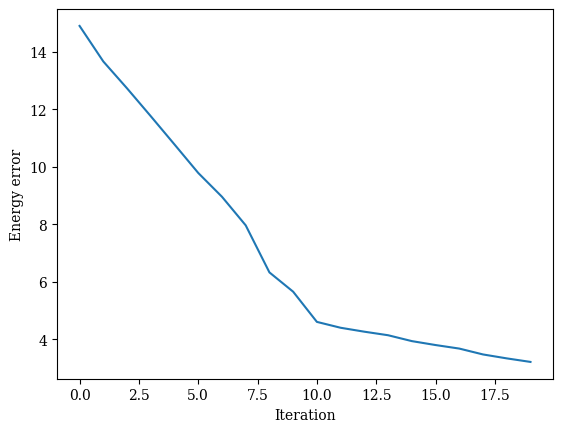

In [73]:
adapt_errors = abs(np.array(adapt_energies) - exact_energy)
fig, ax = plt.subplots()
ax.plot(adapt_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

In [74]:
adapt_errors = np.abs(np.array(adapt_energies) - exact_energy)

## Get circuit expectation values.

In [75]:
simulator_energies = []
for circuit in circuits:
    sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=adapt_mps_bond)
    estimator = BackendEstimator(backend=sim)
    # The circuit needs to be transpiled to the AerSimulator target
    pass_manager = generate_preset_pass_manager(3, sim)
    isa_circuit = pass_manager.run(circuit)
    isa_circuit = RemoveFinalMeasurements()(isa_circuit)
    pub = (isa_circuit, h_qiskit)
    job = estimator.run([pub])
    result = job.result()
    pub_result = result[0]
    exact_value = float(pub_result.data.evs)
    simulator_energies.append(exact_value)

In [76]:
simualtor_errors = np.abs(np.array(simulator_energies) - exact_energy)

Text(0, 0.5, 'Energy error')

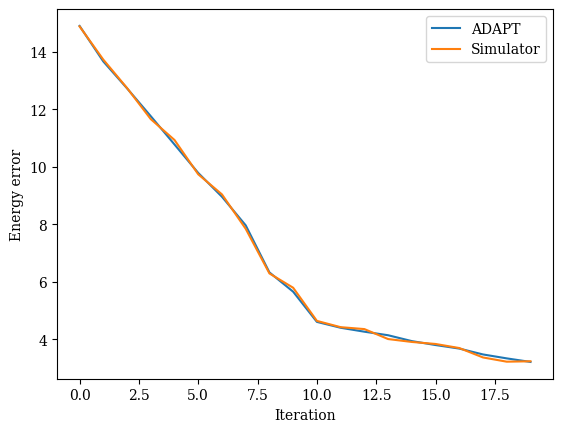

In [77]:
fig, ax = plt.subplots()
ax.plot(adapt_errors, label="ADAPT")
ax.plot(simualtor_errors, label="Simulator")
ax.legend()
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Carry out SQD.

In [78]:

# spin_a_layout = list(range(0, 12))
# spin_b_layout = [12, 13, 14, 15, 19, 35, 34, 33, 32, 31, 30, 29]
# initial_layout = spin_a_layout + spin_b_layout
initial_layout = range(nq)

# sim = AerSimulator.from_backend(computer, method="matrix_product_state")
sim = AerSimulator(method="matrix_product_state", matrix_product_state_max_bond_dimension=4 * adapt_mps_bond)

pass_manager = generate_preset_pass_manager(
    optimization_level=3, backend=sim, initial_layout=initial_layout[:nq]
)


In [79]:
shots_per_circuit = 10_000
num_shots = len(circuits) * shots_per_circuit
sampler = Sampler(sim)

In [80]:

bit_arrays = []
counts_list = []
for i, circuit in enumerate(circuits):
    print(f"On circuit {i}/{len(circuits)}")
    pass_manager.pre_init = ffsim.qiskit.PRE_INIT
    to_run = pass_manager.run(circuit)
    print(f"Gate counts (w/ pre-init passes): {to_run.count_ops()}")
    # job = sim.run(to_run)
    # counts = job.result().data()['counts']
    # bit_array = BitArray.from_counts(counts, num_bits=circuit.num_qubits)
    # counts1 = bit_array.get_counts()
    # num_shots = (i+1) * shots_per_circuit
    job = sampler.run((circuit,), shots=num_shots)
    data = job.result()[0].data
    bit_array = data['meas']
    counts1 = bit_array.get_counts()
    counts_list.append(counts1)
    bit_arrays.append(deepcopy(bit_array))

On circuit 0/20
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'x': 9, 'cx': 6, 'rx': 2, 'h': 2, 'barrier': 2, 'rz': 1})
On circuit 1/20
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'cx': 10, 'x': 9, 'rx': 4, 'h': 4, 'barrier': 3, 'rz': 2})
On circuit 2/20
Gate counts (w/ pre-init passes): OrderedDict({'measure': 20, 'cx': 16, 'x': 9, 'rx': 6, 'h': 6, 'barrier': 4, 'rz': 3})
On circuit 3/20
Gate counts (w/ pre-init passes): OrderedDict({'cx': 22, 'measure': 20, 'x': 9, 'rx': 8, 'h': 8, 'barrier': 5, 'rz': 4})
On circuit 4/20
Gate counts (w/ pre-init passes): OrderedDict({'cx': 28, 'measure': 20, 'rx': 10, 'h': 10, 'x': 9, 'barrier': 6, 'rz': 5})
On circuit 5/20
Gate counts (w/ pre-init passes): OrderedDict({'cx': 34, 'measure': 20, 'rx': 12, 'h': 12, 'x': 9, 'barrier': 7, 'rz': 6})
On circuit 6/20
Gate counts (w/ pre-init passes): OrderedDict({'cx': 40, 'measure': 20, 'rx': 14, 'h': 14, 'x': 9, 'barrier': 8, 'rz': 7})
On circuit 7/20
Gate counts (w/ pre-

In [81]:
energies = []
errors = []

for bit_array in bit_arrays[1:]:
    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    energies.append(min_energy)
    errors.append(err)

Text(0, 0.5, 'Energy error')

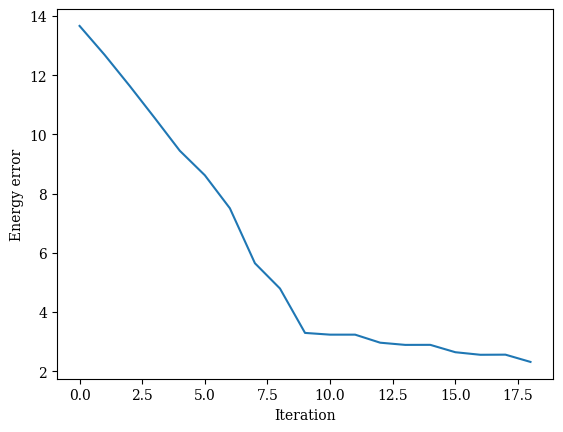

In [82]:
fig, ax = plt.subplots()
ax.plot(errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

## Concatenate mulitple rounds

In [83]:
def randomly_combine_bit_arrays(bit_arrays: List[BitArray], total_shots: int) -> BitArray:
    """Combine several bit arrays by choosing the same number of shots from each of them.
    Choose the shots randomly from each one."""

    shots_per_circuit = [total_shots // len(bit_arrays)] * len(bit_arrays)
    difference = total_shots - sum(shots_per_circuit)
    i = 0
    while i < difference:
        shots_per_circuit[i] += 1
        i += 1
    assert sum(shots_per_circuit) == total_shots

    random_bit_matrices: List[np.ndarray] = []
    num_bits = bit_arrays[0].num_bits
    for i, bit_array in enumerate(bit_arrays):
        assert bit_array.num_shots >= shots_per_circuit[i]
        assert bit_array.num_bits == num_bits
        bit_matrix = bit_array.to_bool_array()
        random_inds = random.sample(list(range(bit_matrix.shape[0])), shots_per_circuit[i])
        random_bit_matrix = bit_matrix[random_inds, :]
        random_bit_matrices.append(random_bit_matrix.copy())
    total_random_bits = np.vstack(random_bit_matrices)
    assert total_random_bits.shape[0] == total_shots
    return BitArray.from_bool_array(total_random_bits)

In [84]:
print(randomly_combine_bit_arrays([bit_arrays[0], bit_arrays[1]], 10))

BitArray(<shape=(), num_shots=10, num_bits=20>)


In [85]:
stacked_energies = []
stacked_errors = []

for i in range(2, len(counts_list) + 1):
    # all_counts = collections.Counter()
    # tuple_of_counts = tuple(counts_list[:i])
    # assert len(tuple_of_counts) == i
    # for counts in tuple_of_counts:
    #     for bitstring, count in counts.items():
    #         all_counts[bitstring] += count

    # bit_array = qiskit.primitives.BitArray.from_counts(all_counts, num_bits=circuits[0].num_qubits)
    bit_array = randomly_combine_bit_arrays(bit_arrays[:i], num_shots)

    bit_matrix = bit_array.to_bool_array()
    eigvals, eigvecs = solve_qubit(bit_matrix, h_qiskit, k=1)
    min_energy = np.min(eigvals)
    err = abs(min_energy - exact_energy)
    stacked_energies.append(min_energy)
    stacked_errors.append(err)


Text(0, 0.5, 'Energy error')

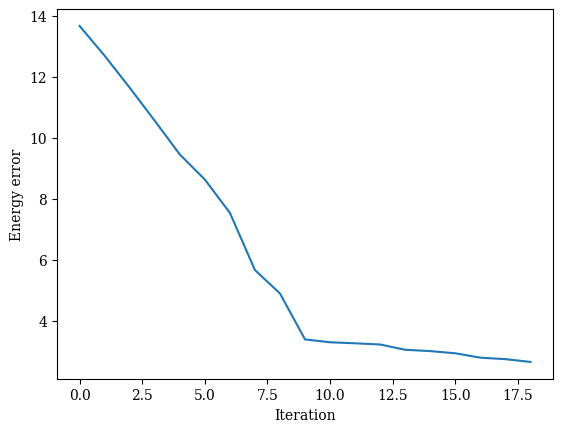

In [86]:
fig, ax = plt.subplots()
ax.plot(stacked_errors)
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")

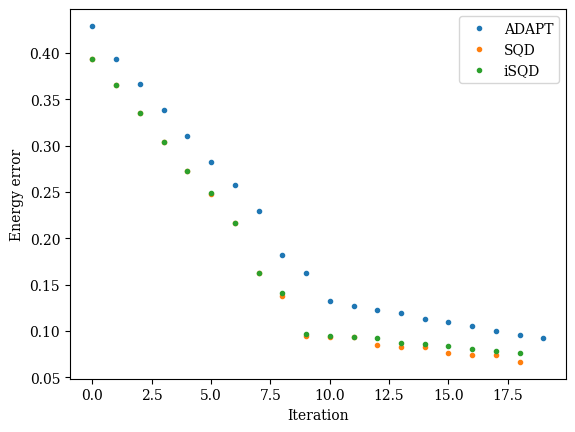

In [87]:
adapt_rel_errors = adapt_errors / abs(exact_energy)
rel_errors = np.array(errors) / abs(exact_energy)
stacked_rel_errors = np.array(stacked_errors) / abs(exact_energy)

fig, ax = plt.subplots()
ax.plot(adapt_rel_errors, '.', label="ADAPT")
ax.plot(rel_errors, '.', label="SQD")
ax.plot(stacked_rel_errors, '.', label="iSQD")
ax.set_xlabel("Iteration")
ax.set_ylabel("Energy error")
ax.legend()

## How many did we keep?

In [88]:
num_kept = []
total_shots = []
for bit_array in bit_arrays:
    bit_matrix = bit_array.to_bool_array()
    original_size = bit_matrix.shape[0]
    bit_matrix = sort_and_remove_duplicates(bit_matrix)
    new_size = bit_matrix.shape[0]
    num_kept.append(new_size)
    total_shots.append(original_size)

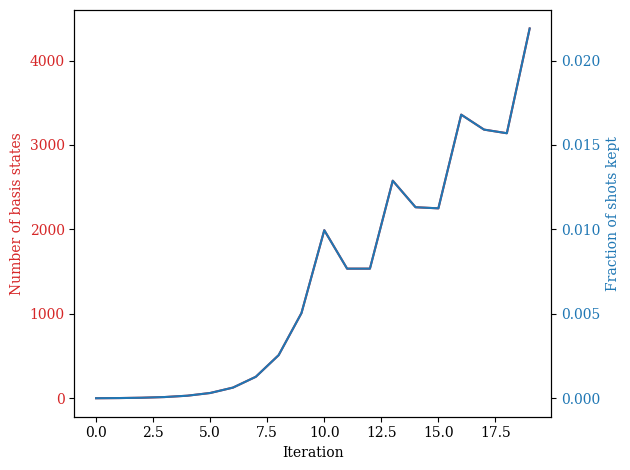

In [89]:
ratio_kept = np.array(num_kept) / np.array(total_shots)

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Iteration')
ax1.set_ylabel('Number of basis states', color=color)
ax1.plot(num_kept, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second Axes that shares the same x-axis

color = 'tab:blue'
ax2.set_ylabel('Fraction of shots kept', color=color)  # we already handled the x-label with ax1
ax2.plot(ratio_kept, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()

In [90]:
qasm_strs = []
for circuit in circuits:
    # print(circuit.num_qubits)
    # isa_circuit = pass_manager.run(circuit)
    # print(isa_circuit.num_qubits)
    isa_circuit = circuit
    qasm_str = dumps(isa_circuit)
    qasm_strs.append(qasm_str)

In [91]:
f = h5py.File("data/xxz_output.hdf5", "w")
f.create_dataset("qasm_strs", data=qasm_strs)
f.create_dataset("exact_energy", data=exact_energy)
f.create_dataset("adapt_errors", data=np.array(adapt_errors))
f.create_dataset("sqd_errors", data=np.array(errors))
f.create_dataset("isqd_errors", data=np.array(stacked_errors))
f.close()